In [1]:
import sys
sys.path.append('../')
from fcc_utils import *

In [152]:
hemato = sc.read('../inputs/mca_hemato.h5ad')

In [153]:
recipe_fcc(hemato, mito_names='mt-')
# see resulting AnnData contents
hemato

AnnData object with n_obs × n_vars = 45214 × 25411 
    obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'ranked_total_counts', 'norm_factor'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'X_gf-icf'

In [154]:
sc.pp.scale(hemato, max_value=10)
sc.tl.pca(hemato, use_highly_variable=False, n_comps=500)

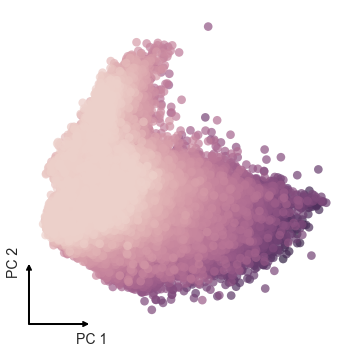

In [155]:
plot_DR(hemato.obsm['X_pca'], color=hemato.obs['log1p_total_counts'], dim_name='PC')

In [156]:
%%time
# create neighborhood graphs from PCA results for UMAP
# heads-up: you will get a numba deprecation warning the first time you run this
sc.pp.neighbors(hemato, n_neighbors=30, use_rep='X_pca', n_pcs=500, knn=True, random_state=18, metric='euclidean', copy=False)

/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/rp_tree.py:450: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$14.16', defined at /Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/rp_tree.py (457)

File "../../../.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/rp_tree.py", line 457:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_euclidean_tree(data, left_indices, rng_state, leaf_size)
        ^

[1] During: resolving callee type: recursive(type(CPUDispatcher(<funct

CPU times: user 1min 7s, sys: 311 ms, total: 1min 7s
Wall time: 1min 7s


In [157]:
# perform Louvain clustering
sc.tl.louvain(hemato, resolution=1.0, key_added='louvain', adjacency=hemato.uns['neighbors']['connectivities'], random_state=18, copy=False)

CPU times: user 8.54 s, sys: 162 ms, total: 8.7 s
Wall time: 8.71 s


/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/scipy/sparse/lil.py:504: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):


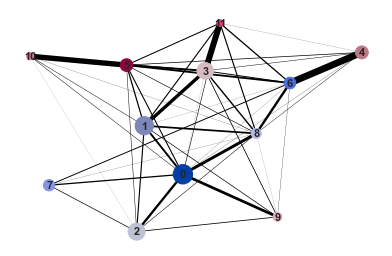

In [158]:
# perform PAGA
sc.tl.paga(hemato)
sc.pl.paga(hemato, frameon=False)

In [159]:
sc.tl.umap(hemato, init_pos=sc.tl._utils.get_init_pos_from_paga(hemato))

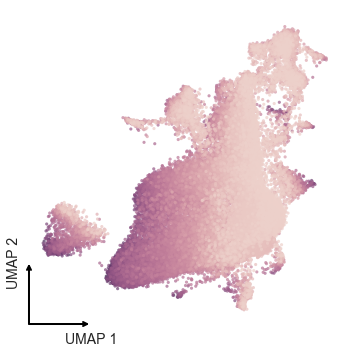

In [161]:
plot_DR(hemato.obsm['X_umap'], color=hemato.obs['log1p_total_counts'], dim_name='UMAP', pt_size=10)

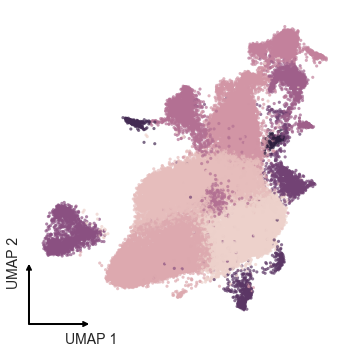

In [189]:
plot_DR(hemato.obsm['X_umap'], color=list(hemato.obs['louvain'].astype(float)), dim_name='UMAP', pt_size=10)

In [ ]:
plot_IDs(hemato, use_rep='X_umap', obs_col='louvain', IDs=['1'], dim_name='UMAP', pt_size=10)

---
Samusik_01

In [204]:
sam = sc.read('../inputs/samusik_01.h5ad')